# Description
In this notebook we explore the attitude update alone, assuming we know the the astrometric parameters of the sources.

In [1]:
# Module import
from IPython.display import Image
import sys
# append to path the folder that contains the analytic scanner
sys.path.append('../GaiaLab/scan/analytic_scanner')
import copy
from tqdm import trange
import quaternion 

# local imports
import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const

from agis import Agis
from agis import Calc_source
from agis_functions import *
from analytic_plots import *

# Ipython magics
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# For scaling: 
Table resuming the scaling that has to be done (not yet implemented). However it can be kept in mind while playing with the parameters.

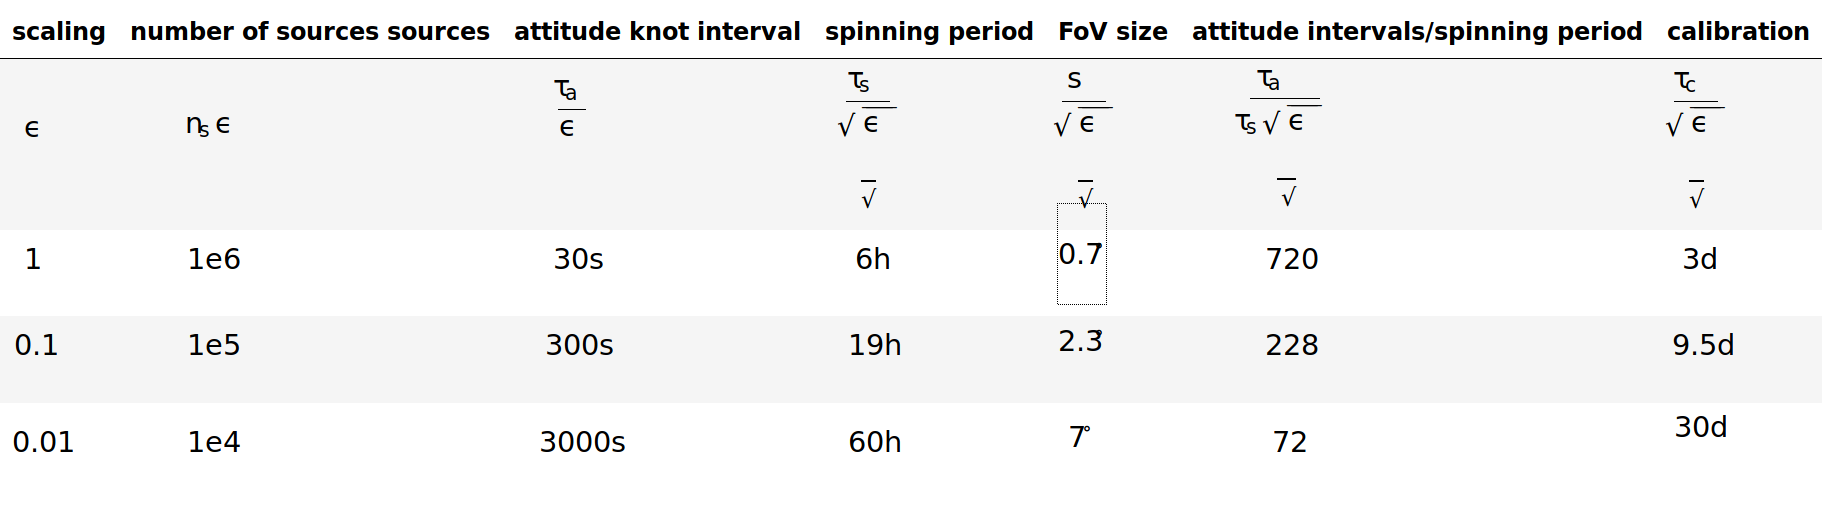

In [2]:
Image('./figures/scaling_factors.png')

# 1.- **Initializing objects:**

### 1.1 satellite

In [3]:
t_init = 0 
t_end =  t_init + 1
my_dt = 1/24/4 # [days]

# objects
spline_degree = 3

gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt, k=spline_degree)
print('#knots:', len(gaia.s_w.get_knots()))

#knots: 95


### 1.2 scanner

In [4]:
double_telescope = True
my_scanner = Scanner(zeta_limit=np.radians(50) ,double_telescope=double_telescope) 

# End scanner

In [5]:
num_times_for_sources=100 # We will create 3 source per given time
times_for_source = np.linspace(t_init, t_end, num=num_times_for_sources, endpoint=True)

alphas, deltas = generate_angles_of_sources(times_for_source, sat=gaia, noise_factor=0)

sources = []
for n in range(len(alphas)):
    sources.append(Source(str(n), np.degrees(alphas[n]), np.degrees(deltas[n]), 0, 0, 0, 0))

# 2- Scan and results

### 2.1 Scan

In [6]:
obs_times = []
calc_sources = []
real_sources = []

# scan the sources and keep as real sources only the ones that are observed
for i in trange(len(sources)):
    s = sources[i]
    my_scanner.scan(gaia, s, ti=t_init, tf=t_end)
    my_scanner.compute_angles_eta_zeta(gaia, s)
    if len(my_scanner.obs_times)>0:
        obs_times += my_scanner.obs_times
        real_sources.append(s)
        calc_sources.append(Calc_source(obs_times=my_scanner.obs_times.copy(), source=s))
sources = real_sources
obs_times = list(np.sort(obs_times))

100%|██████████| 300/300 [00:01<00:00, 150.47it/s]


In [7]:
# check for consistency
if list(np.array(obs_times)[np.where(np.array(obs_times)>t_end)]):
    raise ValueError('observed time greater than end time')

### 2.2 Visualise results of scan

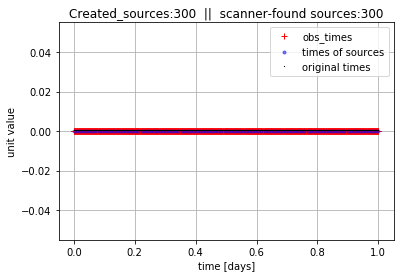

In [8]:
# Plot the distribution of sources and observation along the time axis
plt.figure()
plt.title('Created_sources:'+str(len(alphas))+'  ||  scanner-found sources:'+str(len(calc_sources)))
plt.plot(obs_times,np.zeros(len(obs_times)), 'r+', label='obs_times')
plt.plot(times_for_source, np.zeros(len(times_for_source)), 'b.', label='times of sources', alpha=0.5)
sampled_times = np.linspace(t_init, t_end, num=500)
plt.plot(sampled_times, np.zeros(len(sampled_times)), 'k,', label='original times')
plt.xlabel('time [days]'), plt.ylabel('unit value') # , plt.ylim((-1e-6, 1e-6))

plt.grid(), plt.legend(), plt.show();

#bins: 95


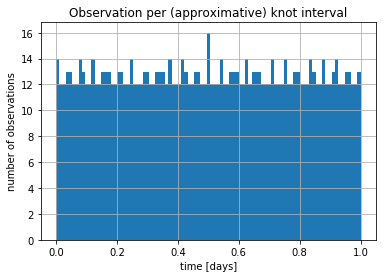

In [9]:
# plot the distibution of observations as a histogram with bin-size approximatively equal 
# to the one the attitude knot interval
plt.figure()
plt.title('Observation per (approximative) knot interval')
knots = gaia.s_x.get_knots()
bins = int(len(knots))
print('#bins:', bins)
plt.hist(obs_times, bins=bins, align='mid');
plt.xlabel('time [days]'), plt.ylabel('number of observations')
plt.grid(), plt.show();


# 3.- *Update Attitude*

### 3.1 Create Solver

In [10]:
spline_degree = 3
Solver = Agis(sat=gaia, calc_sources=calc_sources, real_sources=sources, updating='attitude',
              double_telescope=double_telescope,
              attitude_splines=[gaia.s_w, gaia.s_x, gaia.s_y, gaia.s_z], 
              spline_degree=spline_degree,
              attitude_regularisation_factor=5e-1)

##### 3.1.1 add noise to attitude
To ignore if we want to start directly with the correct attitude

In [11]:
# Ignore this cell if you don't want to modify the initial attitude
# Can be used to check that when recreating the splines in the solver we (almost) do not create additional errors
my_times = np.array(obs_times)
print('Error before Noise: ', Solver.error_function())
c_noise = Solver.att_coeffs * np.random.rand(Solver.att_coeffs.shape[0], Solver.att_coeffs.shape[1]) * 1e-4
last_coef = 4
Solver.att_coeffs[:last_coef] = Solver.att_coeffs[:last_coef] + c_noise[:last_coef]
Solver.actualise_splines()
print('Error after Noise: ', Solver.error_function())

Error before Noise:  0.0
Error after Noise:  6.59376184544286e-10


### 3.2 Visualize Solver data

##### 3.2.1 Visualize attitude

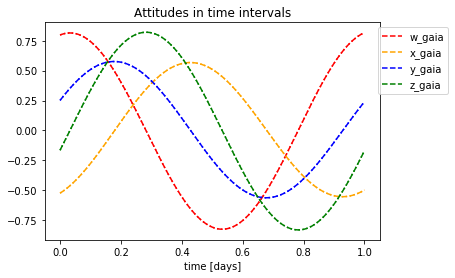

In [12]:
# compare initial difference between satellite and solver attitudes
fig = compare_attitudes(gaia, Solver, obs_times)


##### 3.2.2 Visualize Matrices

In [13]:
# Compute Normal matrix
N_aa = Solver.compute_attitude_LHS()

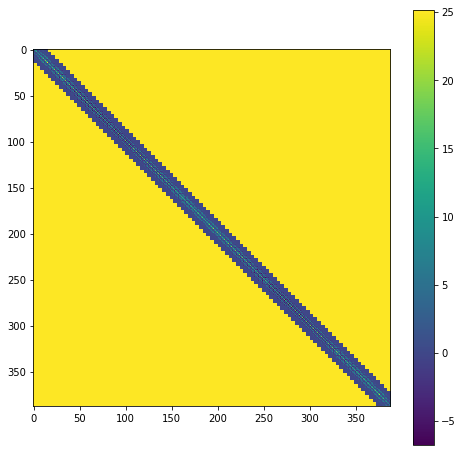

In [14]:
A=N_aa.copy()
plt.figure(figsize=(8,8))
threshold = 0
A[np.where(A==threshold)] = A.max()
plt.imshow(A, vmin=None, vmax=None)
plt.colorbar()
plt.show();

##### 3.2.3 Visualize eigen properties of Normal matrix

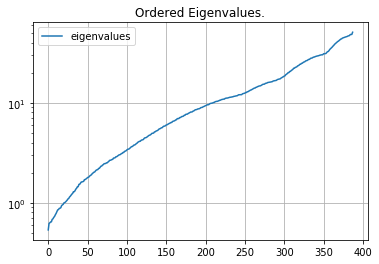

In [15]:
eig_vals, eig_vecs = np.linalg.eigh(N_aa)
plt.figure()

plt.title('Ordered Eigenvalues.')
plt.semilogy(eig_vals, label='eigenvalues')
plt.legend()
plt.grid(), plt.show();

### 3.3 **Iterate**

In [16]:
errors = []  # list to store the errors
errors.append(Solver.error_function())
Solver.iterate(1, verbosity=1)
errors.append(Solver.error_function())

***** Iteration: 1 *****
Error after iteration: 1.8575039581532315e-09


##### 3.3.1 Visualized residuals

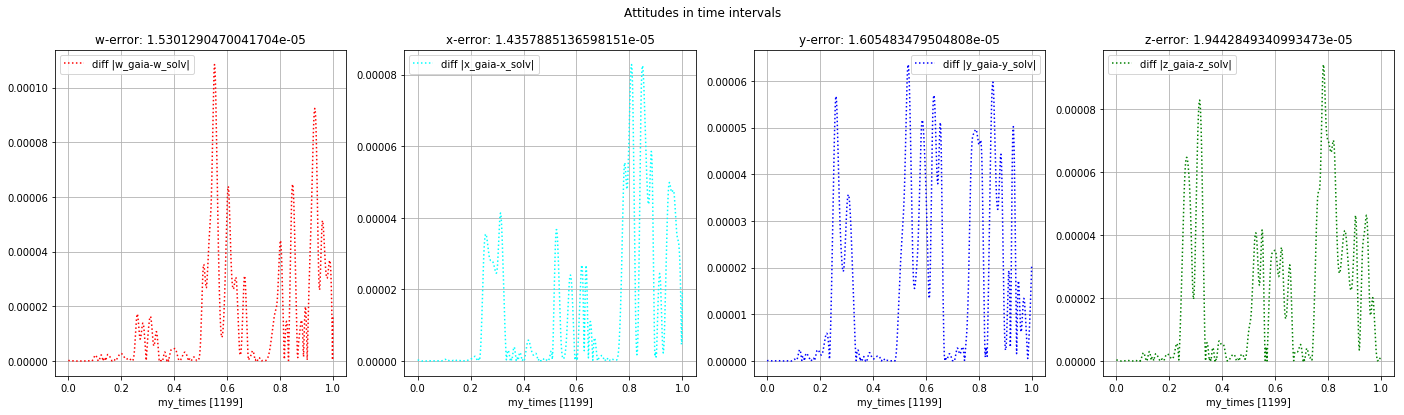

In [17]:
fig3 = multi_compare_attitudes_errors(gaia, Solver, obs_times)

##### 3.3.2 Iterate more

In [18]:
for i in range(5):
    Solver.iterate(1, verbosity=1)
    errors.append(Solver.error_function())

***** Iteration: 2 *****
Error after iteration: 1.6699062049270805e-09
***** Iteration: 3 *****
Error after iteration: 1.6881300348329626e-09
***** Iteration: 4 *****
Error after iteration: 1.6859992932822886e-09
***** Iteration: 5 *****
Error after iteration: 1.6862654923069757e-09
***** Iteration: 6 *****
Error after iteration: 1.686227991817902e-09


##### 3.3.3 Visualize convergence

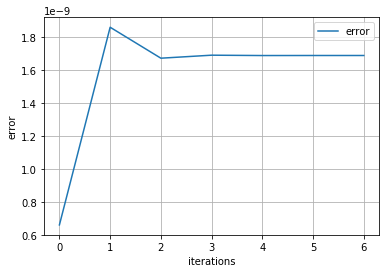

In [19]:
plt.figure()
plt.plot(errors[:], label='error')
plt.grid(), plt.legend(), plt.xlabel('iterations'), plt.ylabel('error')
plt.show()

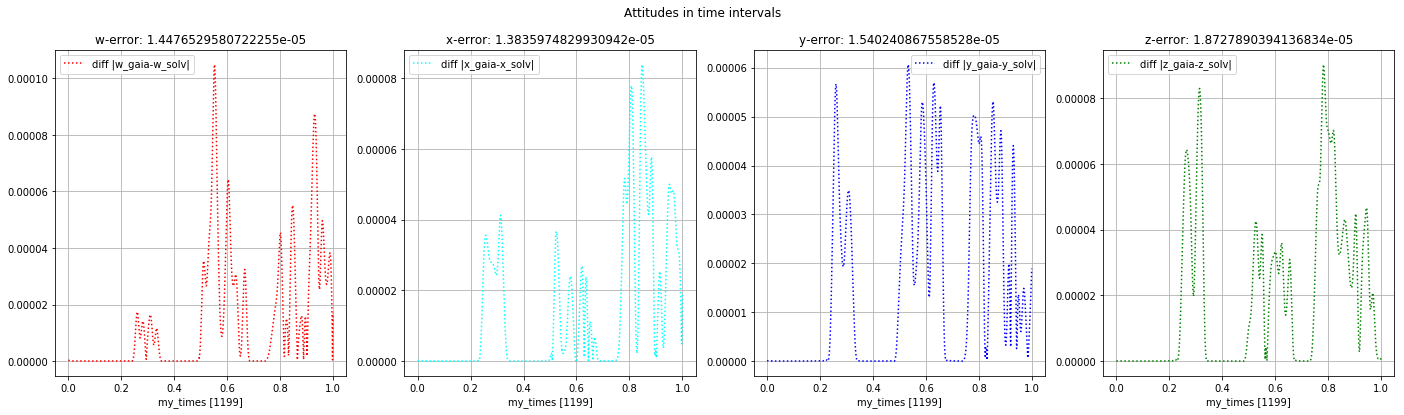

In [20]:
fig3 = multi_compare_attitudes_errors(gaia, Solver, obs_times);

# 4.- Conclusion
We hope you enjoyed this notebook! For any question, bugs, doubts, do not hesitate to contact us. 